## This notebook plot simplified SEI equations 

In [314]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl; 
fs=17
font = {'family' : 'DejaVu Sans',  'size'   : fs}
mpl.rc('font', **font)

import os
str_path_0 = os.path.abspath(os.path.join(pybamm.__path__[0],'../..'))
Save_fig_path = str_path_0 + "/examples/Reproduce_Paper"

In [315]:
# write functions first
# note that all three diffusion limited model share the same expression 
F = 96485.33289
epsilon_s_n = 0.75 # negative electrode porosity
R_n = 5.86e-6   # negative particle radius
b_n = 3 * epsilon_s_n / R_n
L_n = 8.52e-05 # negative electrode thickness
A  = 0.065 * 1.58
R = 8.314

def Q_loss_diffusion_limited_SEI(L_SEI_0, a, b, t):
    y = ( -L_SEI_0 + np.sqrt(
        L_SEI_0**2 + 2* a * b * t
    ) ) / a
    return y

def Q_loss_solvent_single(D_EC, c_EC, t):
    s = 2
    V_bar_sei = 9.585e-05
    fan_L = np.sqrt(2*s*F/V_bar_sei)
    Q_loss = (b_n * L_n * A) * fan_L * np.sqrt(F*D_EC*c_EC)* np.sqrt(t) 
    return Q_loss

def get_a():
    z_sei = 2
    V_bar_sei = 9.585e-05
    a = 1 / (
        z_sei * F * b_n * L_n * A / V_bar_sei
    )
    return a 
def get_b_intestitial(U_n, T, D_int):
    c_Li_0_ref = 15
    # D_int = 2e-16
    b = c_Li_0_ref * b_n * L_n * A * D_int * F * np.exp(
        - F * U_n / (R*T) # T in K
    )
    return b

def get_b_solvent(D_sol):
    c_sol_0 = 2636.0
    b = b_n * L_n * A * F * D_sol * c_sol_0 
    return b

def get_b_migration(U_n, R_SEI):
    # R_SEI = 2E5
    U_SEI_inner =  0.1 # Inner SEI open-circuit potential [V]
    b = b_n * L_n * A * abs(U_SEI_inner - U_n) / R_SEI
    return b

def Q_loss_reaction_limited_SEI(U_n, j_SEI_0, T, t):
    U_SEI = 0.4 # SEI open-circuit potential [V]
    y = b_n * L_n * A * j_SEI_0 * np.exp(
        0.5 * F * (U_SEI - U_n) / (R*T) 
    ) * t
    return y


In [316]:
def graphite_LGM50_ocp_Chen2020(sto):
    """
    LG M50 Graphite open-circuit potential as a function of stochiometry, fit taken
    from [1].

    References
    ----------
    .. [1] Chang-Hui Chen, Ferran Brosa Planella, Kieran O’Regan, Dominika Gastol, W.
    Dhammika Widanage, and Emma Kendrick. "Development of Experimental Techniques for
    Parameterization of Multi-scale Lithium-ion Battery Models." Journal of the
    Electrochemical Society 167 (2020): 080534.

    Parameters
    ----------
    sto: :class:`pybamm.Symbol`
        Electrode stochiometry

    Returns
    -------
    :class:`pybamm.Symbol`
        Open-circuit potential
    """

    u_eq = (
        1.9793 * np.exp(-39.3631 * sto)
        + 0.2482
        - 0.0909 * np.tanh(29.8538 * (sto - 0.1234))
        - 0.04478 * np.tanh(14.9159 * (sto - 0.2769))
        - 0.0205 * np.tanh(30.4444 * (sto - 0.6103))
    )

    return u_eq

In [317]:
# give values for parameters
L_SEI_0 = 2.5e-9
j_SEI_0 = 1.15e-7
R_SEI = 1e9
D_int = 2e-16
D_sol = 3e-20
c_sol_0 = 2636.0
# define ageing conditions here: ageing T and storage SOC
T = 273.15 + 25 # ageing temperature in K
U_n = graphite_LGM50_ocp_Chen2020(0.1)

t_list = np.arange(0, 60, 1, dtype=float) * 60 * 24 * 360 # default units: second
# diffusion limited:
a = get_a()
b_int = get_b_intestitial(U_n, T, D_int)
Q_int = [Q_loss_diffusion_limited_SEI(L_SEI_0, a, b_int, t) for t in t_list]

b_sol = get_b_solvent(D_sol)
Q_sol = [Q_loss_diffusion_limited_SEI(L_SEI_0, a, b_sol, t) for t in t_list]
Q_sol_single = [
    Q_loss_solvent_single(D_sol, c_sol_0, t)
    for t in t_list]
b_mig = get_b_migration(U_n, R_SEI) 
Q_mig = [Q_loss_diffusion_limited_SEI(L_SEI_0, a, b_mig, t) for t in t_list]

Q_rec = [Q_loss_reaction_limited_SEI(U_n, j_SEI_0, T, t) for t in t_list]


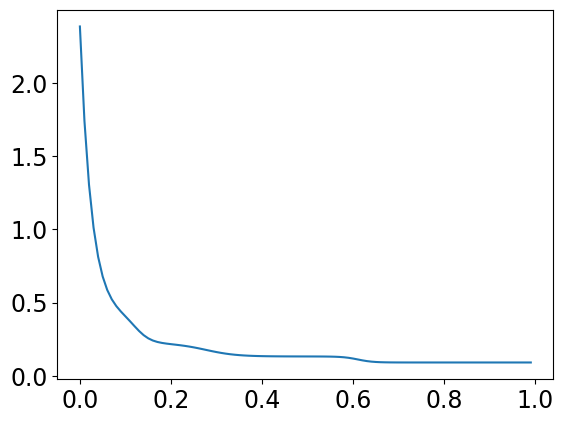

In [318]:
sto_list = np.arange(0, 1, 0.01, dtype=float) 
plt.plot(sto_list, graphite_LGM50_ocp_Chen2020(sto_list))

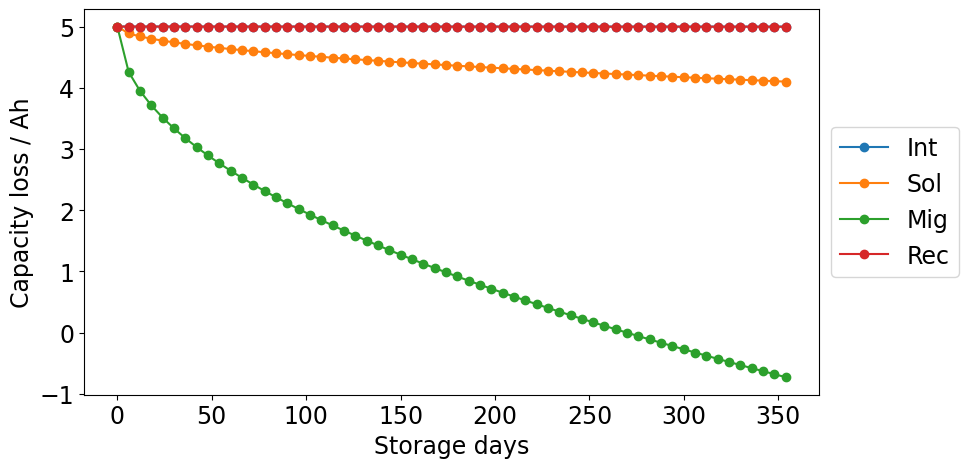

In [319]:
fig, axs = plt.subplots( figsize=(10,5),tight_layout=True)
Q_list = [ 
    Q_int, 
    Q_sol, 
    Q_mig, 
    Q_rec 
]
labels = [
    "Int",
    "Sol",
    "Mig",
    "Rec"
]
for Q, label in zip(Q_list, labels):
    axs.plot(t_list/3600/24, 5- np.array(Q)/3600, "-o", label = label)
axs.set_ylabel("Capacity loss / Ah")
axs.set_xlabel("Storage days")
axs.legend(prop={'size':fs-3}, loc='best')
axs.legend(loc='center left', bbox_to_anchor=(1, 0.5))

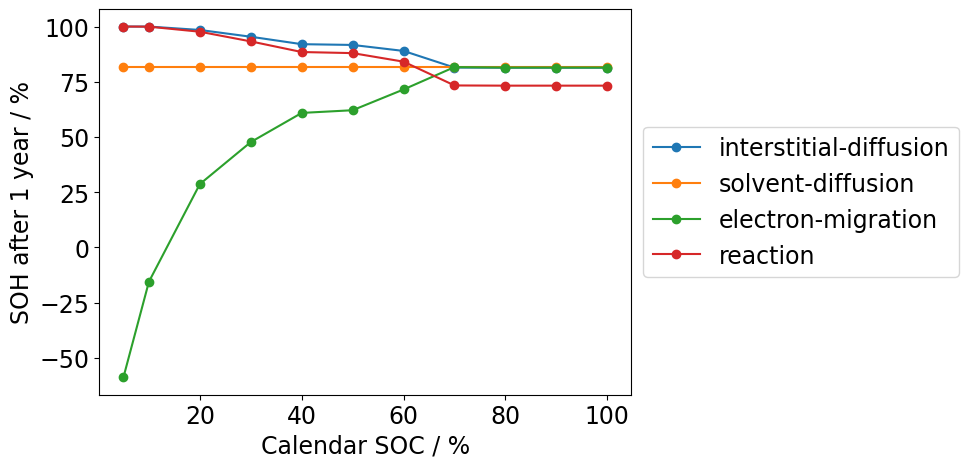

In [327]:
# compare results of SOC dependency 
Calendar_soc = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90,  100] 
Calendar_soc = np.array(Calendar_soc)/ 100
U_n_list = [graphite_LGM50_ocp_Chen2020(sto) for sto in Calendar_soc]
t = 60 * 60 * 24 * 360 # one year

b_int_list = [get_b_intestitial(U_n, T, D_int) for U_n in U_n_list]
Q_int_SOC = [Q_loss_diffusion_limited_SEI(L_SEI_0, a, b_int, t) for b_int in b_int_list]

Q_sol_SOC = [Q_loss_diffusion_limited_SEI(L_SEI_0, a, b_sol, t) for sto in Calendar_soc]

b_mig_list = [get_b_migration(U_n, R_SEI) for U_n in U_n_list ]
Q_mig_SOC = [Q_loss_diffusion_limited_SEI(L_SEI_0, a, b_mig, t) for b_mig in b_mig_list]

Q_rec_SOC = [Q_loss_reaction_limited_SEI(U_n, j_SEI_0, T, t) for U_n in U_n_list]

# plot with electron conduction
fig, axs = plt.subplots( figsize=(10,5),tight_layout=True)
Q_list_SOC = [ 
    Q_int_SOC, 
    Q_sol_SOC, 
    Q_mig_SOC, 
    Q_rec_SOC 
]
labels = [
    "interstitial-diffusion",
    "solvent-diffusion",
    "electron-migration",
    "reaction"
]
for Q, label in zip(Q_list_SOC, labels):
    axs.plot(Calendar_soc*100, 100 - np.array(Q)/3600 / 5*100, "-o", label = label)
axs.set_ylabel("SOH after 1 year / %")
axs.set_xlabel("Calendar SOC / %")
#axs.set_ylim(70, 103)
axs.legend(prop={'size':fs-3}, loc='best')
axs.legend(loc='center left', bbox_to_anchor=(1, 0.5))


fig.savefig(
    Save_fig_path + 
    "/Simplified SEI submodel store at different SOC wo ylim.png", dpi=600)

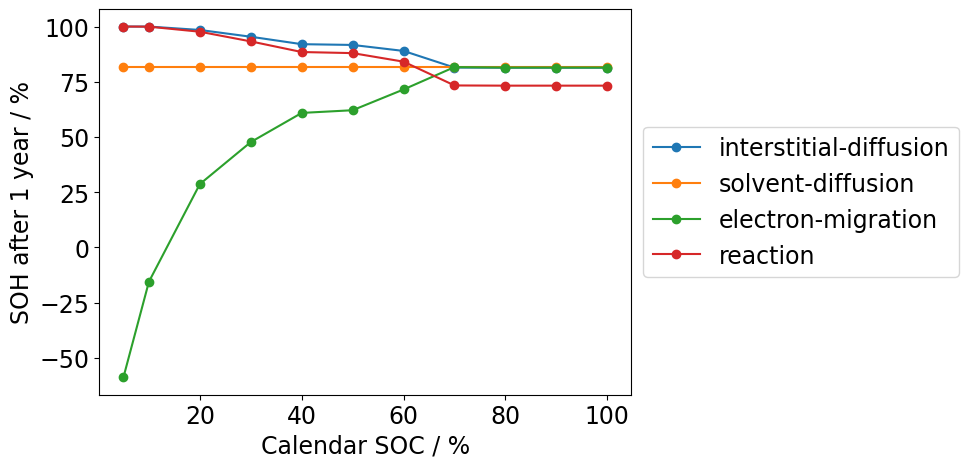

In [325]:
# plot with electron conduction
fig, axs = plt.subplots( figsize=(10,5),tight_layout=True)
Q_list_SOC = [ 
    Q_int_SOC, 
    Q_sol_SOC, 
    Q_mig_SOC, 
    Q_rec_SOC 
]
labels = [
    "interstitial-diffusion",
    "solvent-diffusion",
    "electron-migration",
    "reaction"
]
for Q, label in zip(Q_list_SOC, labels):
    axs.plot(Calendar_soc*100, 100 - np.array(Q)/3600 / 5*100, "-o", label = label)
axs.set_ylabel("SOH after 1 year / %")
axs.set_xlabel("Calendar SOC / %")
axs.legend(prop={'size':fs-3}, loc='best')
axs.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.savefig(
    Save_fig_path + 
    "/Simplified SEI submodel store at different SOC w electron conduction.svg")
fig.savefig(
    Save_fig_path + 
    "/Simplified SEI submodel store at different SOC w electron conduction.png", dpi=600)